In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from collections import OrderedDict
from typing import List
from scipy.io import loadmat
from time import ctime

import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
matlab_data = loadmat("Project_IV_Data.mat..bin")

u_bc_cases = matlab_data['u_bc']
u_data_cases = matlab_data['u_data']
v_data_cases = matlab_data['v_data']
x_2d = matlab_data['x_2d']
y_2d = matlab_data['y_2d']

case_index = 0

u_bc = u_bc_cases[case_index, :]
u_data = u_data_cases[case_index, :, :]
v_data = v_data_cases[case_index, :, :]

In [5]:
# 作为偏微分方程的解的代理模型的神经网络
# 待预测参数应该有三个：速度分量和压强
class DNN(torch.nn.Module):

    def __init__(self, layers: List[int]):
        super().__init__()
        
        # 网络深度和激活函数
        self.depth = len(layers) + 1
        self.activation = torch.nn.Tanh

        # 有序字典储存网络的各层结构
        layer_list = list()
        layer_list.append(
            ('layer_inp', torch.nn.Linear(2, layers[0]))  # 输入层，固定两个节点：坐标
        )
        for i in range(len(layers)-1): 
            layer_list.append(
                (f'layer_{i}', torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_out', torch.nn.Linear(layers[-1], 3))  # 输出层，固定三个输出节点：速度分量和压强
        )
        layerDict = OrderedDict(layer_list)
        
        # 序列式构造神经网络
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x: torch.tensor):
        out = self.layers(x)
        return out

In [10]:
# 控制偏微分方程内的各个系统参数，对上面的解进行优化
# 包含一个控制参数：粘滞系数mu
class PINN():

    def __init__(self, layers, x_2d, y_2d, u_data, v_data, u_bc, x_bc, y_bc):

        # 读取边界条件,，二维数据
        self.u_bc = torch.tensor(u_bc).float().to(device)
        self.x_bc = torch.tensor(x_bc).float().to(device)
        self.y_bc = torch.tensor(y_bc).float().to(device)
        
        # 读取采样数据点，三维数据
        self.x_2d = torch.tensor(x_2d, requires_grad=True).float().to(device) 
        self.y_2d = torch.tensor(y_2d, requires_grad=True).float().to(device)
        self.u_data = torch.tensor(u_data).float().to(device)  # 采样点的速度场
        self.v_data = torch.tensor(v_data).float().to(device)  # 采样点的速度场

        # 控制参数，在训练过程中也会被优化
        self.mu = torch.tensor([0.0], requires_grad=True).to(device)  # 粘滞系数
        self.mu = torch.nn.Parameter(self.mu)

        
        # 定义偏微分方程的解
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('mu', self.mu)  # 待优化的控制参数
        
        # 定义优化器
        self.iter = 0
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

    # 预测采样点上的速度场和压强
    def predict(self, x, y):  
        output = self.dnn(torch.stack([x, y], dim=x.dim()))
        return output

    # 预测采样点上的数值微分，实现内嵌NS方程
    def physics(self, x, y):

        mu = self.mu
        output = self.predict(x, y) 
        u = output[:, :, 0]
        v = output[:, :, 1]
        P = output[:, :, 2]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]  # 速度u对x方向的偏导
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]  # 速度u对y方向的偏导
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]  # 速度v对x方向的偏导
        v_y = torch.autograd.grad(
            v, y, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]  # 速度v对y方向的偏导
        P_x = torch.autograd.grad(
            P, x, 
            grad_outputs=torch.ones_like(P),
            retain_graph=True,
            create_graph=True
        )[0]  # P对x方向的偏导
        P_y = torch.autograd.grad(
            P, y, 
            grad_outputs=torch.ones_like(P),
            retain_graph=True,
            create_graph=True
        )[0]  # P对y方向的偏导
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]  # 速度u对x方向的二阶偏导(二维下就是拉普拉斯算子)
        u_yy = torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True
        )[0]  # 速度u对y方向的二阶偏导(二维下就是拉普拉斯算子)
        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]  # 速度v对x方向的二阶偏导(二维下就是拉普拉斯算子)
        v_yy = torch.autograd.grad(
            v_y, y, 
            grad_outputs=torch.ones_like(v_y),
            retain_graph=True,
            create_graph=True
        )[0]  # 速度v对y方向的二阶偏导(二维下就是拉普拉斯算子)
        
        # 物理方程
        fu = u * u_x + v * u_y + P_x - mu * (u_xx + u_yy)  # NS方程的x方向分量
        fv = u * v_x + v * v_y + P_y - mu * (v_xx + v_yy)  # NS方程的y方向分量
        fm = u_x + v_y  # 质量守恒（不可压缩流体，速度散度为0

        return fu, fv, fm

    def loss_func(self):
        
        # 内部采样点数据，一般意义上的损失函数
        output = self.predict(self.x_2d, self.y_2d) 
        u_pred = output[:, :, 0]
        v_pred = output[:, :, 1]
        fu_pred, fv_pred, fm_pred = self.physics(self.x_2d, self.y_2d)
        internal_loss = torch.mean((self.u_data - u_pred) ** 2) + torch.mean((self.v_data - v_pred) ** 2)

        # 边界数据，边界上数值的损失函数
        output = self.predict(self.x_bc, self.y_bc)  # 可以考虑添加其他边上的损失
        u_bc_pred = output[:, 0]
        boundary_loss = torch.mean((self.u_bc - u_bc_pred) ** 2)

        # 内嵌物理的损失
        physical_loss = torch.mean(fu_pred ** 2) + torch.mean(fv_pred ** 2) + torch.mean(fm_pred ** 2) 
        
        return internal_loss + boundary_loss + physical_loss
    
    def train(self, nIter):

        self.dnn.train()
        for epoch in range(nIter):
            
            # 反向传播优化
            loss = self.loss_func()
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(f'It: {epoch}, Loss: {loss.item():.3e} Mu: {float(self.mu):8.3e}')

        # L-BFGS优化
        self.optimizer_lbfgs.step(self.loss_func)



In [12]:
# pinn = PINN([20, 20, 20], x_2d, y_2d, u_data, v_data, u_bc, x_bc=np.linspace(0, 1, 65), y_bc=np.zeros(65))
pinn = torch.load("/home/super/RSAG/project/Sat_Dec_30_20_20_35_2023.pth")
pinn.train(5000)  # 实测上10000代都不够收敛，需要调学习率


It: 0, Loss: 1.382e-01 Mu: -5.697e-03
It: 100, Loss: 1.339e-01 Mu: -2.405e-03
It: 200, Loss: 1.259e-01 Mu: -5.716e-04
It: 300, Loss: 1.101e-01 Mu: -3.157e-03
It: 400, Loss: 9.169e-02 Mu: -8.958e-04


KeyboardInterrupt: 

<Axes: >

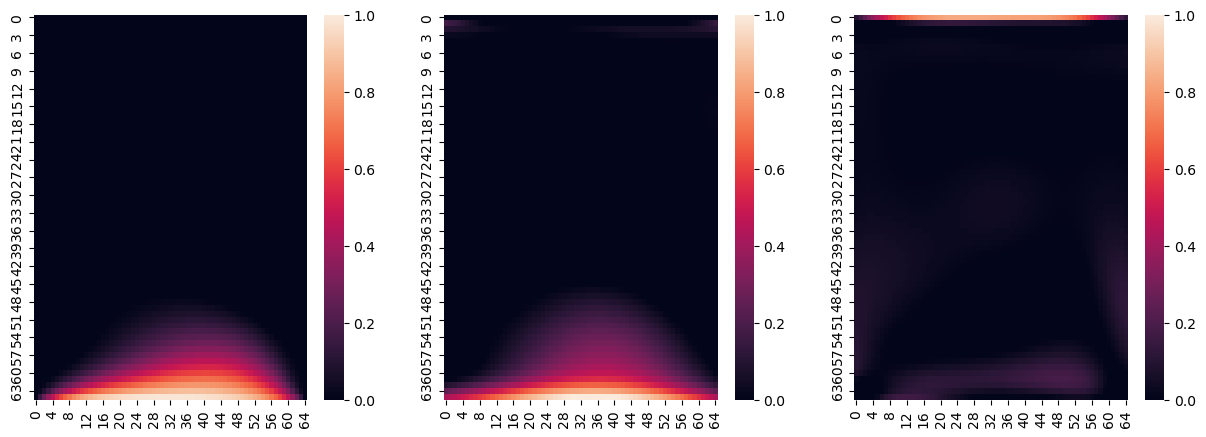

In [ ]:
vmin = 0
vmax = 1

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(pinn.u_data.cpu().numpy(), vmin=vmin, vmax=vmax, ax=axes[0])
sns.heatmap(pinn.predict(pinn.x_2d, pinn.y_2d)[:, :, 0].cpu().detach().numpy(), vmin=vmin, vmax=vmax, ax=axes[1])
sns.heatmap(pinn.u_data.cpu().numpy()-pinn.predict(pinn.x_2d, pinn.y_2d)[:, :, 0].cpu().detach().numpy(), vmin=vmin, vmax=1, ax=axes[2])

<Axes: >

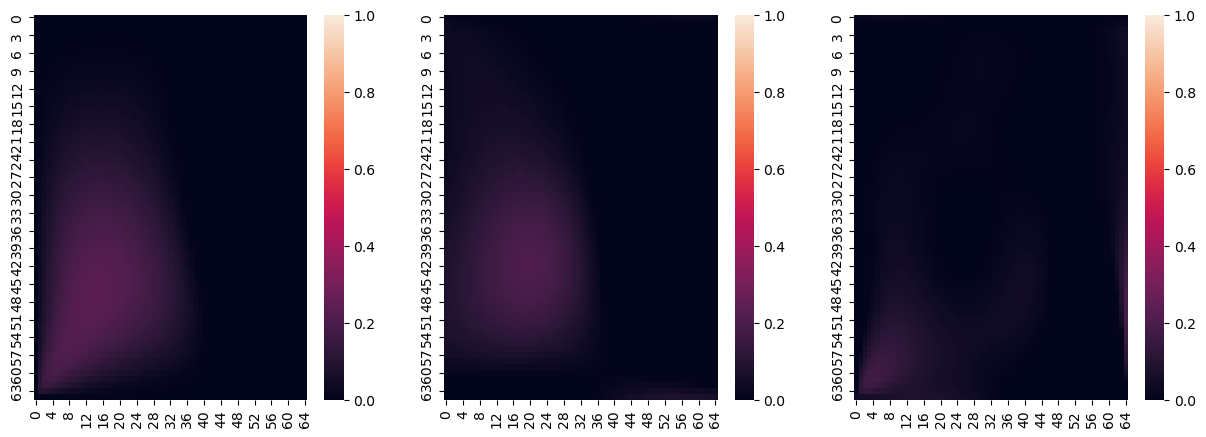

In [ ]:
vmin = 0
vmax = 1

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(pinn.v_data.cpu().numpy(), vmin=vmin, vmax=vmax, ax=axes[0])
sns.heatmap(pinn.predict(pinn.x_2d, pinn.y_2d)[:, :, 1].cpu().detach().numpy(), vmin=vmin, vmax=vmax, ax=axes[1])
sns.heatmap(pinn.v_data.cpu().numpy()-pinn.predict(pinn.x_2d, pinn.y_2d)[:, :, 1].cpu().detach().numpy(), vmin=vmin, vmax=1, ax=axes[2])

In [ ]:
torch.save(pinn, f'{ctime().replace(" ", "_").replace(":", "_")}.pth')